## 第零部分 初始化

In [57]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [58]:
# read the file
df = pd.read_csv('input1016.csv')

# print the head
df.head()

,xau,date,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,...,lsu,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu
0,0.000000,1979/1/1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.353357,1979/1/2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.682500,1979/1/3,0.353357,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.060062,1979/1/4,-3.682500,0.353357,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.047597,1979/1/5,2.060062,-3.682500,0.353357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


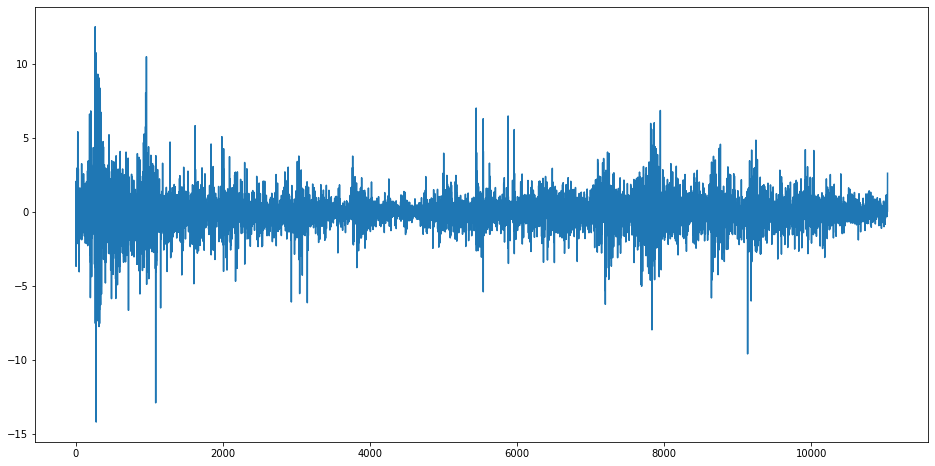

In [59]:
# setting index as date
# df['Ndate'] = pd.to_datetime(df.Ndate,format='%Y-%m-%d')
# df.index = df['Ndate']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['xau'], label='Price History')

In [60]:
# splitting into train and validation
train = df[:5500].copy()
valid = df[5500:].copy()

df.shape, train.shape, valid.shape

((11039, 33), (5500, 33), (5539, 33))

## 第一部分 滑动平均

In [61]:
#make predictions
preds = []
for i in range(0,5539):
    a = train['xau'][len(train)-5539+i:].sum() + sum(preds)
    b = a/5539
    preds.append(b)
preds

397527934e-05,
 1.152177687350065e-05,
 0.00039352635274944716,
 0.0002892021661368382,
 -3.314348070083693e-05,
 4.049387758031109e-05,
 -9.693656746796194e-05,
 -0.0003969366639777076,
 -0.0005218406321423562,
 -0.0003720321639408956,
 -0.0005375455326291026,
 -0.0005252088327794196,
 -0.0005532675520126382,
 -0.0003472858467503164,
 -0.0006802759691274152,
 -0.0008949261812539944,
 -0.0012480599146320903,
 -0.0010681360588665402,
 -0.0010441726136704514,
 -0.0014122389158213254,
 -0.0014332062635223188,
 -0.0013207396352976472,
 -0.0014307459977521114,
 -0.0014664618587374432,
 -0.0012050727509307518,
 -0.0009063245055346406,
 -0.0005155713770828487,
 -0.0006025811328830113,
 -0.00029033264346847254,
 -4.93258167205905e-05,
 -0.00020195669735187724,
 -0.0004472845860858302,
 -0.0009464101900912653,
 -0.0013462238079266261,
 -0.001046811835153191,
 -0.0006344118918123593,
 -0.0012334865819896138,
 -0.0009928679449760752,
 -0.0011559669536319636,
 -0.0010477259973137871,
 -0.001153361

In [62]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['xau'])-preds),2)))
rms

1.004162729040933

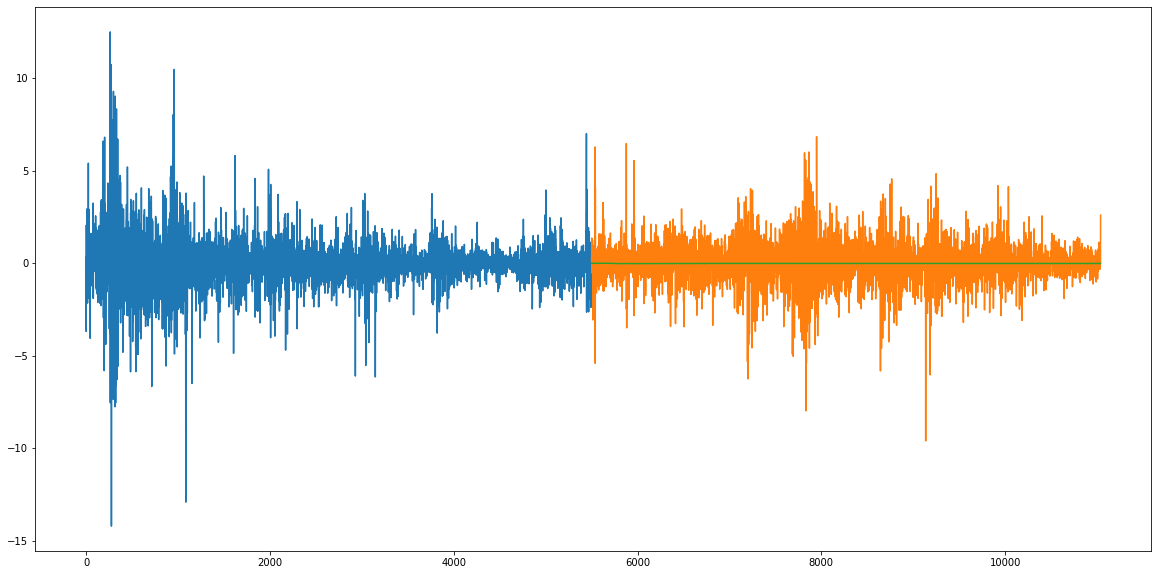

In [63]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['xau'])
plt.plot(valid[['xau', 'Predictions']])

## 第二部分 长短期记忆网络(LSTM)

In [64]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

In [65]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['xau'])
for i in range(0,len(data)):
    new_data['xau'][i] = data['xau'][i]

In [66]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:5500,:]
valid = dataset[5500:,:] 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))

In [67]:
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

In [68]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=5, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 69s - loss: 0.0040
Epoch 2/100


KeyboardInterrupt: 

In [0]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [0]:
#for plotting
rcParams['figure.figsize'] = 20,10
train = new_data[:5500].copy()
valid = new_data[5500:].copy()
valid['Predictions'] = closing_price
plt.plot(train['xau'])
plt.plot(valid[['xau','Predictions']])

In [0]:
type(valid)

In [0]:
valid.to_csv('LSTM_predict_v4.csv')

## 第三部分 神经网络

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
import keras as k
import os
 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
df = pd.read_csv('../res/model1117.csv')

In [90]:
df.head()

,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,djci,dji,...,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu,Target
0,0.008947,-0.015993,0.001535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.004550,0.008947,-0.015993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.004647,0.004550,0.008947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.001748,-0.004647,0.004550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.006446,0.001748,-0.004647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [91]:
Y_PRED = []
Y_TEST = []
accuracy = []
precision = []
recall = []
f1 = []
df = df.reindex(np.random.permutation(df.index))
# 黄金价格涨跌放在最后一列，列名叫‘Target’，涨和不变记为1，跌记为0
x = df.iloc[:10000, :-1]
y = df.iloc[:10000, -1]

In [92]:
# 填参数的数目
num_parameters = 31

In [93]:
# 十折
sfolder = StratifiedKFold(n_splits=10, shuffle=True, random_state=1218)
all_y_test = []
for train, test in sfolder.split(x, y):
    batch_size = 128
    max_epochs = 64
    model = k.models.Sequential()
    # 每层神经元数可调
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True, input_shape=(num_parameters, )))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dropout(0.5))
    model.add(k.layers.Dense(units=2, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    x_train = x.iloc[train.tolist(), :]
    y_train = y.iloc[train.tolist()]
    model.fit(x_train, np_utils.to_categorical(y_train, num_classes=2), batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=1)
    x_test = x.iloc[test.tolist(), :]
    y_test = y.iloc[test.tolist()]
    y_test = y_test.reset_index()['Target']
    y_pred = model.predict(x_test)
    test_0_num = 0
    test_0_pred_0 = 0
    test_1_num = 0
    test_1_pred_1 = 0
    for index in range(0, len(y_test)):
        if y_test[index] == 0:
            test_0_num = test_0_num + 1
            if y_pred[index][0] < 0.5:
                test_0_pred_0 = test_0_pred_0 + 1
        else:
            test_1_num = test_1_num + 1
            if y_pred[index][1] > 0.5:
                test_1_pred_1 = test_1_pred_1 + 1
    accuracy = accuracy + [(test_1_pred_1 + test_0_pred_0) / (test_0_num + test_1_num)]
    precision = precision + [test_1_pred_1 / (test_1_pred_1 + test_0_num - test_0_pred_0)]
    recall = recall + [test_1_pred_1 / (test_1_pred_1 + test_0_pred_0)]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/64
8999/8999 [==============================] - 4s 477us/step - loss: 0.2900 - mean_absolute_error: 0.4450
Epoch 2/64
8999/8999 [==============================] - 1s 121us/step - loss: 0.2563 - mean_absolute_error: 0.4187
Epoch 3/64
8999/8999 [==============================] - 1s 122us/step - loss: 0.2446 - mean_absolute_error: 0.4196
Epoch 4/64
8999/8999 [==============================] - 1s 115us/step - loss: 0.2366 - mean_absolute_error: 0.4177
Epoch 5/64
8999/8999 [==============================] - 1s 124us/step - loss: 0.2272 - mean_absolute_error: 0.4123
Epoch 6/64
8999/8999 [==============================] - 1s 118us/step - loss: 0.2221 - mean_absolute_error: 0.4108
Epoch 7/64
8999/8999 [==============================] - 1s 126us/step - loss: 0.2190 - mean_absolute_error: 0.4106
Epoch 8/64
8999/8999 [==============================] - 1s 132us/step - loss: 0.

KeyboardInterrupt: 

In [0]:
model.save('4NN.model')
[accuracy, precision, recall]

In [0]:
y_output = []
y_1_num = 0
y_0_num = 0
for index in range(0, len(y_pred)):
        if y_pred[index][0] < 0.5:
            y_1_num = y_1_num + 1
            y_output.append(1)
        else:
            y_0_num = y_0_num + 1
            y_output.append(0)
y_1_num,y_0_num

In [0]:
test_1_num,test_0_num

In [0]:
y_pred


In [0]:
comp_df = pd.DataFrame(y_test)
comp_df['Out'] = pd.DataFrame(y_output)
comp_df.to_csv('test_vs_out4.csv')

In [6]:
import keras as k
import pandas as pd
import matplotlib as plt
def ModelPredict(input):
    model = k.models.load_model('4NN.model')# 加载保存下来的模型
    return model.predict(input)# 直接用加载出来的模型，对输入 input 进行预测
df = pd.read_csv('../res/model1117.csv')

x = df.iloc[:10000, :-1]
y = df.iloc[:10000, -1]

x = x.iloc[[i for i in range(10000)],:]
y_pred = ModelPredict(x)

# print(y_pred)
# print(y)
# print(y[0])
y_output = []
for index in range(0, len(y_pred)):
        if y_pred[index][0] < 0.5:
            y_output.append(1)
        else:
            y_output.append(0)

# print(y_output)

continues_suc = 0
continues_fail = 0


result = []
maxx = 0
for i in range(0,len(y_output)):
    if y_output[i] == y[i]:
        continues_suc+=1
        if continues_fail!=0:
            result.append(-continues_fail)
            if continues_fail > maxx:
                maxx = continues_fail
            continues_fail = 0
    else:
        continues_fail+=1
        if continues_suc != 0:
            result.append(continues_suc)
            if continues_suc > maxx:
                maxx = continues_suc
            continues_suc = 0

length = maxx+1
suc_result = [[0] * length for i in range(length)]
fail_result = [[0]*length for i in range(length)]

for i in range(len(result)-1):
    if result[i]>0:
        suc_result[result[i]][-result[i+1]]+=1
    else:
        fail_result[-result[i]][result[i+1]]+=1
print(suc_result)


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 642, 266, 108, 56, 22, 9, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 375, 149, 59, 37, 4, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 200, 80, 36, 13, 6, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 118, 43, 23, 6, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 63, 18, 9, 3, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 38, 15, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 12, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 16, 4, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,